# SVMs on Extended MNIST
 
**Project Specifications :** Developing a classifier o distinguish digits from non-digits.

**Tasks :**

* Combining multiple datasets
* Selecting the SVM parameters (`C` and `gamma`) via `cross-validation`.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## EMNIST Dataset

The extended dataset of MNIST (called EMNIST)

*Dataset Reference :* Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373

* `emnist-digits.mat`:  This is a file of digits `0` to `9`, with multiple examples per class.
* `emnist-letters.mat`:  This is a file of letters `a/A` to `z/Z`.  The lower and upper case letters are grouped into the same class.

Creating a function using the `scipy.io` package to extract the relevant fields from the MATLAB file.  Specifically, the function extracts the training and test data from MATLAB file. 

In [0]:
import scipy.io
def load_emnist_dig(file_path='C:/emnist-digits.mat'):
    
    mat = scipy.io.loadmat(file_path)
    
    # training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

def load_emnist_let(file_path='C:/emnist-letters.mat'):

    mat = scipy.io.loadmat(file_path)
    
    # training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [0]:
# digit data from emnist-digits.mat
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist_dig()

240000 training samples, 40000 test samples loaded


In [0]:
# non-digit data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist_let()

124800 training samples, 20800 test samples loaded


In [0]:
def plt_char(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)        

**Plotting 8 random samples from the digit and letter training data.**

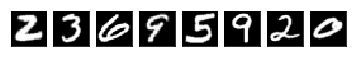

In [0]:
nplt = 8
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)

for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_char(Xtr_dig[ind,:])


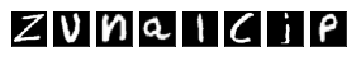

In [0]:
nplt = 8
nsamp = Xtr_let.shape[0]
Iperm = np.random.permutation(nsamp)

for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_char(Xtr_let[ind,:])

## Creating a Non-Digit Class

SVM classifiers are VERY SLOW to train.  The training is particularly slow when there are a large number of classes, so lumping all of the letters in one class and add that class to the digits.  

Before we begin, we first need to remove all the letters corresponding to `i/I`, `l/L` and `o/O`.  The reason is that these letters would get confused with the digits `0` and `1`.  

Using `Python broadcasting` and `np.all(..., axis=1)` command created arrays `Xtr_let_rem` and `ytr_let_rem` from the data `Xtr_let` and `ytr_let`, where the samples `i` with `ytr_let[i] == 9, 12` or `15` are removed. Also created `Xts_let_rem` and `yts_let_rem` similarly.



In [0]:
v = np.where(ytr_let == 9)
v1 = np.where(ytr_let == 12)
v2 = np.where(ytr_let == 15)
rem_arr = v+v1+v2

Xtr_let_rem = np.delete(Xtr_let, rem_arr, axis=0)
ytr_let_rem = np.delete(ytr_let, rem_arr, axis=0)

v = np.where(yts_let == 9)
v1 = np.where(yts_let == 12)
v2 = np.where(yts_let == 15)
rem_arr = v+v1+v2

Xts_let_rem = np.delete(Xts_let, rem_arr, axis=0)
yts_let_rem = np.delete(yts_let, rem_arr, axis=0)


In [0]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# Sub-sampled training and test data
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)

Xtr1_dig = Xtr_dig[Iperm[:ntr_dig],:]
ytr1_dig = ytr_dig[Iperm[:ntr_dig]]

nsamp = Xtr_let_rem.shape[0]
Iperm = np.random.permutation(nsamp)

Xtr1_let = Xtr_let_rem[Iperm[:ntr_let],:]
ytr1_let = ytr_let_rem[Iperm[:ntr_let]]

nsamp = Xts_dig.shape[0]
Iperm = np.random.permutation(nsamp)

Xts1_dig = Xts_dig[Iperm[:nts_dig],:]
yts1_dig = yts_dig[Iperm[:nts_dig]]

nsamp = Xts_let_rem.shape[0]
Iperm = np.random.permutation(nsamp)

Xts1_let = Xts_let_rem[Iperm[:nts_let],:]
yts1_let = yts_let_rem[Iperm[:nts_let]]
 

**Combining the digit and letter arrays using the `np.hstack` and `np.vstack` methods..**

* An array `Xtr` by stacking `Xtr1_dig`, `Xtr1_let`. 6000 total samples.
* A new label vector `ytr` where `ytr[i] = ytr1_dig[i]` for any digit sample and `ytr[i]=10` for any letter sample.  Thus, all the letters are lumped into a single class with label 11.
* Creating test arrays `Xts` and `yts` similarly. 



In [0]:
Xtr = np.vstack((Xtr1_dig, Xtr1_let))
ytr = np.hstack((ytr1_dig, 10*np.ones(1000)))

Xts = np.vstack((Xts1_dig, Xts1_let))
yts = np.hstack((yts1_dig, 10*np.ones(1000)))

# Rescaling data

The training data above takes values from 0 to 255.  Rescaling the data from -1 to 1 will get slightly better performance on the SVM.
The scaled data are saved into arrays `Xtr1` and `Xts1`.

In [0]:
Xtr1 = Xtr/255.0*2 - 1
Xts1 = Xts/255.0*2 - 1

## Running the SVM classifier

Using an `rbf` classifier with `C=2.8` and `gamma=.0073`.

In [0]:
from sklearn import svm

# A support vector classifier
svc = svm.SVC(probability=False, kernel="rbf", C=2.8, gamma=.0073,verbose=10)

# Fit the classifier

In [0]:
svc.fit(Xtr1,ytr)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

# Measuring the accuracy on the test data.

In [0]:
from sklearn.metrics import accuracy_score

y_pred = svc.predict(Xts1)
acc = accuracy_score(yts,y_pred)

error_rate = 1 - acc
print("Accuracy on the test data =",acc)
print("Error data on the test data =",error_rate)

Accuracy on the test data = 0.9141666666666667
Error data on the test data = 0.08583333333333332


# Printing a confusion matrix.

[[0.948 0.    0.    0.    0.002 0.002 0.    0.    0.004 0.    0.022]
 [0.    0.981 0.002 0.    0.    0.002 0.    0.    0.    0.    0.008]
 [0.    0.002 0.915 0.    0.    0.    0.    0.008 0.006 0.    0.037]
 [0.002 0.    0.004 0.921 0.    0.006 0.    0.002 0.014 0.    0.023]
 [0.    0.002 0.    0.    0.897 0.    0.    0.    0.    0.006 0.047]
 [0.    0.    0.    0.013 0.    0.896 0.    0.    0.002 0.002 0.042]
 [0.    0.004 0.    0.    0.    0.008 0.919 0.    0.    0.    0.032]
 [0.    0.    0.002 0.    0.004 0.    0.    0.953 0.    0.008 0.017]
 [0.002 0.004 0.004 0.002 0.002 0.004 0.    0.002 0.904 0.    0.038]
 [0.    0.    0.    0.009 0.004 0.002 0.    0.006 0.006 0.934 0.021]
 [0.028 0.017 0.034 0.017 0.028 0.077 0.019 0.006 0.03  0.048 0.848]]


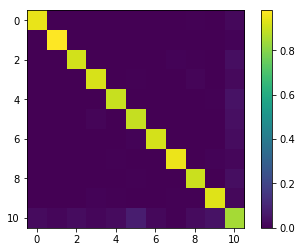

In [0]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,y_pred)

# Normalizing the confusion matrix
Csum = np.sum(C, axis = 1)
C =np.divide(C,Csum)

print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [0]:
# Error rates
err_digaslet = np.sum(C[:10,10])/11
err_letasdig = 1 - C[10,10] 
print("The fraction of digits are mislabeled as letters = %.3f" % err_digaslet )
print("The fraction of letters are mislabeled as digits = %.3f" % err_letasdig )

The fraction of digits are mislabeled as letters = 0.026
The fraction of letters are mislabeled as digits = 0.152


## Selecting gamma and C via Cross-Validation (Using For-Loops)

Trying different values of `gamma` and `C` to select the pair of values with the lowest test error rate.

In [0]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

for i in range(nC):
    for j in range(ngam):
        svc = svm.SVC(probability=False, kernel="rbf", C= C_test[i], gamma=gam_test[j], verbose=10)
        svc.fit(Xtr1,ytr)
        y_pred = svc.predict(Xts1)
        acci = accuracy_score(yts,y_pred)
        acc[i,j] = acci


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [0]:
# Accuracy matrix
print(acc)

[[0.79033333 0.5925     0.16666667]
 [0.87116667 0.891      0.2205    ]
 [0.89916667 0.89683333 0.22316667]]


In [0]:
# The maximum accuracy and the corresponding best C and gamma

[Coptarg,gamOptarg] = np.unravel_index(np.argmax(acc, axis=None), acc.shape)
print("The maximum accuracy = %.6f" %acc[Coptarg,gamOptarg])
print("The corresponding value of C =", C_test[Coptarg])
print("The corresponding value of gamma =", gam_test[gamOptarg])



The maximum accuracy = 0.899167
The corresponding value of C = 10
The corresponding value of gamma = 0.001
